In [1]:
#Блок в рамках которого импотряться математические подсчеты, падас и нампай
import pandas as pd
import numpy as np
from scipy.stats import iqr
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats
import scipy as sp


import os
#Блок в рамках которого импотряться графики
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pyplot import figure
sns.set_style('darkgrid')


#Блок в рамках которого импотряться статистические пакеты
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import het_white, het_goldfeldquandt, het_breuschpagan
from statsmodels.stats.outliers_influence import reset_ramsey
from statsmodels.stats.diagnostic import compare_encompassing 

# Содержание работы

[Обработка и получение данных](#Introduction)
#### Выполнение заданий:
1. [Задание 1](#subparagraph1) -  Оценка линейной модели
2. [Задание 2](#subparagraph2) - Оценка полулогорифмической модели
3. [Задание 3](#subparagraph3) - Оценка линейной в логарифмах модели
4. [Задание 4](#subparagraph4) - Выбор модели (Тест Бокса-Кокса с преообразованием Зарембки)
5. [Задание 5](#subparagraph5) - Тестирование различия в ЗП (Тест Чоу)
6. [Задание 6](#subparagraph6) - Тестирование наличие выборосов (DFbettas, Leverage, Dffits)
7. [Задание 7](#subparagraph7) - Поиск мультиколлиниарности (VIF)
8. [Задание 8](#subparagraph8) - Применение PCA
9. [Задание 9](#subparagraph9) - Построение графика остатки-прогнозы
10. [Задание 10](#subparagraph10) - Тестирование гетероскедостичности (Тест Уйта, Голдфелда — Куандта, Бройша — Пагана
11. [Задание 11](#subparagraph11) - Проведение Теста Рамсея
12. [Задание 12](#subparagraph12) - Оценка и сравнение модели
13. [Задание 13](#subparagraph13) - Предложение функциональных форм
14. [Задание 14](#subparagraph14) - Итоговая оценка модели

### 0. Предварительный EDA

In [2]:
# making "directoryback"
os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [3]:
data = pd.read_csv('Data/PhonesDF_years.csv')
data.sample(3)

,phone_title,price,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,battery_type,disp_height,disp_width,oper_syst_type,oper_syst_vers,brand,year_of_release
119,Oppo A31 4GB/64GB,17999.0,3.3,61,32,6.50,8.0,64.0,4.0,4230.0,Li-Po,1600.0,720.0,Android,9,Oppo,2015
618,Realme 6 4GB/128GB,777.0,5.0,100,7,6.50,16.0,128.0,4.0,4300.0,Li-Po,2400.0,1080.0,Android,10,Realme,2020
720,Xiaomi Redmi 9C 2GB/32GB,9199.0,5.0,58,2,6.53,5.0,32.0,2.0,5000.0,Li-Po,1600.0,720.0,Android,10,Xiaomi,2020


In [4]:
# adding log price and PPI to dataset
data['log_price'] = np.log(data.price)
data['density'] = data.disp_height * data.disp_width / data.disp_diag

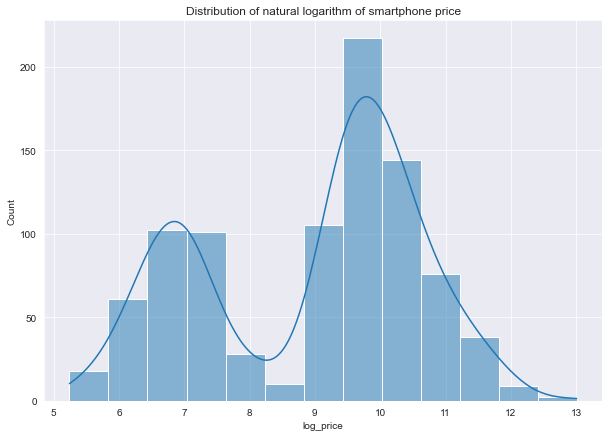

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что у нас получилось бимодальное распределение, где каждый колокол напомоминает нормальное распределение. Скорее всего, это связано с тем, что у нас в датасете есть много некорректно указанных цен (ошибка с порядком цены), так как в левой части распределения телефоны имеют цену ниже 2000 рублей, что выглядит неправдоподобно.

Избавимся от этих выбросов и построим новое распределение цены:

In [6]:
# correcting and saving data
data = data.loc[(data.price >= np.exp(8.3)) & (data.price < np.exp(12.5)), :].copy(deep=True)
data.to_csv('Data/PhonesDF_years_corrected.csv', index=False)

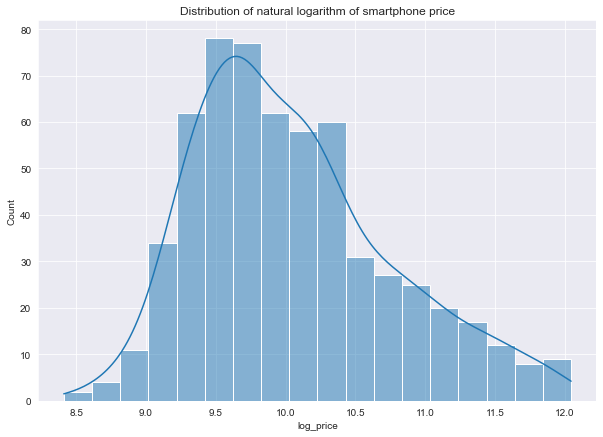

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что распределение логарифма цены имеет правостороннюю ассиметрию.

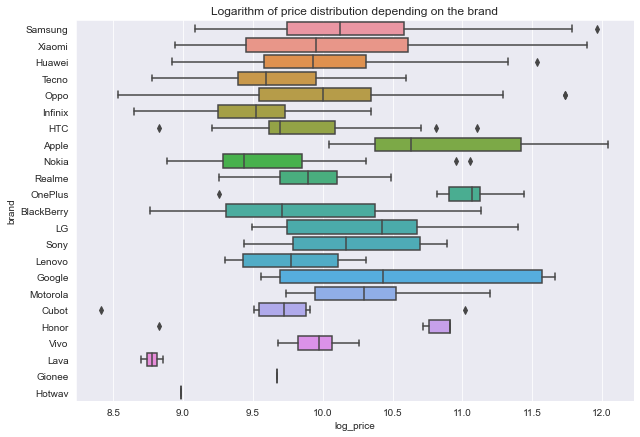

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=data, y='brand', x='log_price', ax=ax, order=list(data.brand.value_counts().index))
ax.set_title('Logarithm of price distribution depending on the brand');

Видно, что айфоны и смартфоны бренда Google сущестсвенно дороже, чем остальные.

Построим, как цена и ее логарифм зависит от числовых характеристик смартфона.

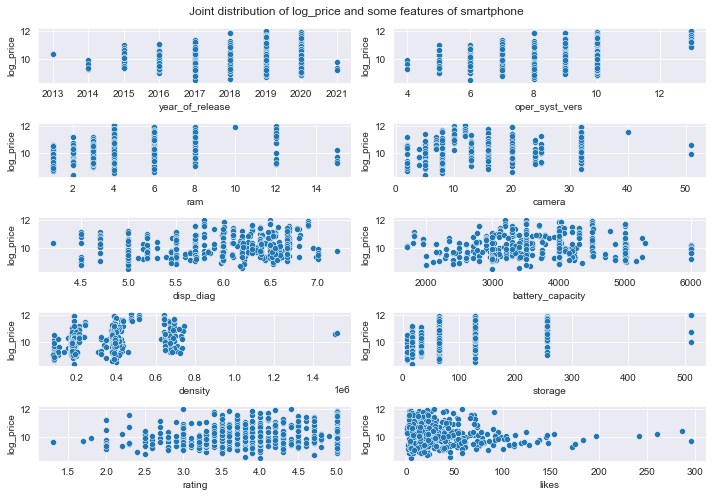

In [9]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='log_price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of log_price and some features of smartphone')
plt.tight_layout();

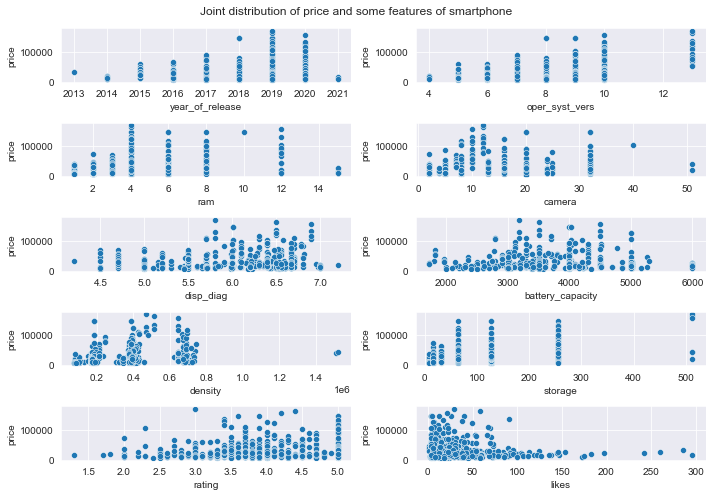

In [10]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of price and some features of smartphone')
plt.tight_layout();

Таким образом, явной линейной и логлинейной звисимости тут не прослеживается. Попробуем отлогарифмировать признаки.

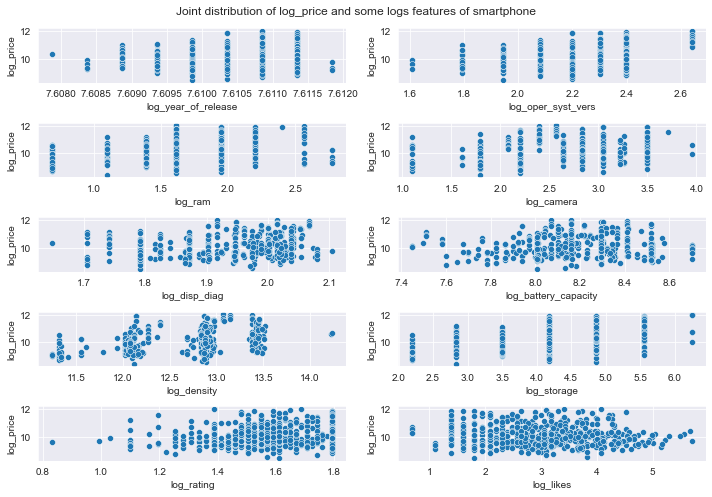

In [11]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.log_price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('log_price')
fig.suptitle('Joint distribution of log_price and some logs features of smartphone')
plt.tight_layout();

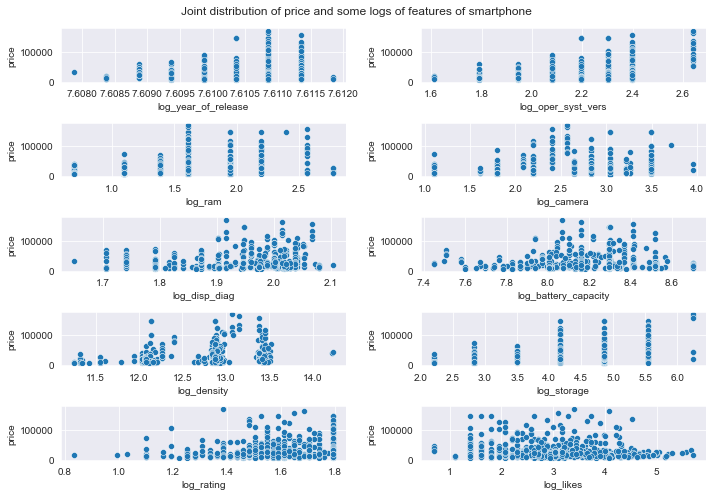

In [12]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('price')
fig.suptitle('Joint distribution of price and some logs of features of smartphone')
plt.tight_layout();

Явных зависимостей тоже не видно, но это всего лишь проекция данных на 2 оси, так что не стоит отчаиваться!

Посмотрим на корреляции 

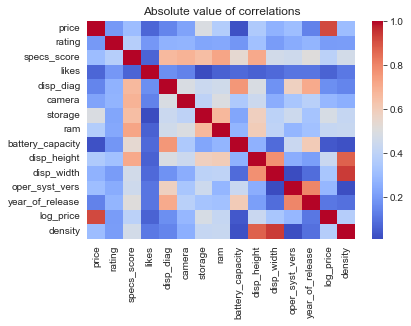

In [13]:
sns.heatmap(np.abs(data.corr()), cmap="coolwarm")
plt.title('Absolute value of correlations');

### 1. Обработка данных

In [14]:
data.sample(3)
data = data.drop(columns = ['price'])

In [15]:
def encode_and_bind(original_dataframe, feature_to_encode, drop = True):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first = True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    if drop == True:
        res = res.drop(columns = [feature_to_encode])
    return(res)

In [16]:
data = data.set_index('phone_title')
unique_brands = list(data['brand'].unique())

In [17]:
data['Other_oper_syst'] = 0
data['IOS_oper_syst'] = 0

data.loc[data['oper_syst_type'] == 'Other', 'Other_oper_syst'] = 1 # Android - base dummy
data.loc[data['oper_syst_type'] == 'IOS', 'IOS_oper_syst'] = 1 
data = data.drop(columns = ['oper_syst_type'])

In [18]:
data = encode_and_bind(data, 'battery_type')
data = encode_and_bind(data, 'brand')

In [19]:
data = data.rename(columns = {'battery_type_ Li-Po':'battery_type_LiPo'})

In [20]:
data.sample(3)

,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
phone_title,,,,,,,,,,,,,,,,,,,,,
Lava Iris 51 1GB/8GB,4.0,32,13,5.0,5.0,8.0,1.0,2500.0,854.0,480.0,...,0,0,0,0,0,0,0,0,0,0
Huawei Y8p 6GB/128GB,3.2,95,33,6.3,16.0,128.0,6.0,4000.0,2400.0,1080.0,...,0,0,0,0,0,0,0,0,0,0
HTC Desire 10 Compact,3.0,45,9,5.0,5.0,32.0,3.0,3300.0,1280.0,720.0,...,0,0,0,0,0,0,0,0,0,0


### 2. EDA

In [21]:
np.round(data.describe(), 2)

,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
count,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,...,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00
mean,3.86,67.43,29.35,6.01,13.43,86.16,4.55,3769.51,1977.03,988.46,...,0.01,0.04,0.03,0.07,0.03,0.17,0.02,0.08,0.01,0.16
std,0.76,21.41,35.90,0.59,8.90,79.97,2.62,852.32,554.18,274.43,...,0.11,0.19,0.17,0.25,0.17,0.38,0.14,0.26,0.09,0.37
min,1.30,28.00,1.00,4.20,2.00,8.00,1.00,1715.00,480.00,480.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.40,51.00,8.00,5.50,7.00,32.00,3.00,3050.00,1520.00,720.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3.90,62.00,17.00,6.20,10.00,64.00,4.00,4000.00,2160.00,1080.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.50,90.00,36.00,6.50,16.00,128.00,6.00,4200.00,2340.00,1080.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,5.00,100.00,296.00,7.20,51.00,512.00,15.00,6000.00,3840.00,3840.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [22]:
def mean_mode_median(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Function for finding mean median and mode of continious data
    '''
    df = pd.DataFrame()
    df['Mode'] = stats.mode(dataframe)[0][0]
    df['Median'] = np.median(dataframe, axis=0)
    df['Mean'] = np.mean(dataframe, axis=0).to_numpy()
    
    df = np.round(df, 2)
    
    df.index = dataframe.columns
    return df

In [23]:
mean_mode_median(data)

,Mode,Median,Mean
rating,5.00,3.90,3.86
specs_score,100.00,62.00,67.43
likes,4.00,17.00,29.35
disp_diag,5.50,6.20,6.01
camera,8.00,10.00,13.43
storage,128.00,64.00,86.16
ram,4.00,4.00,4.55
battery_capacity,4000.00,4000.00,3769.51
disp_height,2340.00,2160.00,1977.03
disp_width,1080.00,1080.00,988.46


### 3. Multicollinearity

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_m = add_constant(data)
data_m = data_m.drop(columns = ['log_price'])
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


c:\Users\Anton\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\Anton\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                 0.000000
rating                1.376302
specs_score           7.548443
likes                 1.567261
disp_diag             7.772052
camera                2.298667
storage               2.756118
ram                   2.895783
battery_capacity      3.606154
disp_height          25.033448
disp_width           16.182949
oper_syst_vers       17.210565
year_of_release      13.301363
density              45.989469
Other_oper_syst       2.081648
IOS_oper_syst              inf
battery_type_LiPo     2.039244
brand_BlackBerry           inf
brand_Cubot                inf
brand_Gionee               inf
brand_Google               inf
brand_HTC                  inf
brand_Honor                inf
brand_Hotwav               inf
brand_Huawei               inf
brand_Infinix              inf
brand_LG                   inf
brand_Lava                 inf
brand_Lenovo               inf
brand_Motorola             inf
brand_Nokia                inf
brand_OnePlus              inf
brand_Op

In [28]:
data_m = data_m.drop(columns = 'IOS_oper_syst')
data = data.drop(columns = 'IOS_oper_syst')

In [29]:
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


const                2.303391e+07
rating               1.376302e+00
specs_score          7.548443e+00
likes                1.567261e+00
disp_diag            7.772052e+00
camera               2.298667e+00
storage              2.756118e+00
ram                  2.895783e+00
battery_capacity     3.606154e+00
disp_height          2.503345e+01
disp_width           1.618295e+01
oper_syst_vers       1.721057e+01
year_of_release      1.330136e+01
density              4.598947e+01
Other_oper_syst      2.081648e+00
battery_type_LiPo    2.039244e+00
brand_BlackBerry     3.994294e+00
brand_Cubot          2.742241e+00
brand_Gionee         1.546396e+00
brand_Google         2.764067e+00
brand_HTC            8.010459e+00
brand_Honor          2.466022e+00
brand_Hotwav         1.298037e+00
brand_Huawei         1.507373e+01
brand_Infinix        9.627554e+00
brand_LG             4.228089e+00
brand_Lava           1.544793e+00
brand_Lenovo         3.887417e+00
brand_Motorola       2.549014e+00
brand_Nokia   

In [33]:
data = data.drop(columns = ['disp_height', 'disp_width', 'specs_score'])
data_m = data_m.drop(columns = ['disp_height', 'disp_width', 'specs_score'])
data_m['density'] = data['density']

In [39]:
np.round(pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns), 2)


const                22897938.89
rating                      1.35
likes                       1.54
disp_diag                   5.29
camera                      1.84
storage                     2.53
ram                         2.63
battery_capacity            3.38
oper_syst_vers             16.97
year_of_release            13.22
density                     1.91
Other_oper_syst             2.06
battery_type_LiPo           1.94
brand_BlackBerry            3.92
brand_Cubot                 2.72
brand_Gionee                1.54
brand_Google                2.72
brand_HTC                   7.85
brand_Honor                 2.41
brand_Hotwav                1.29
brand_Huawei               14.70
brand_Infinix               9.50
brand_LG                    4.12
brand_Lava                  1.52
brand_Lenovo                3.84
brand_Motorola              2.52
brand_Nokia                 5.84
brand_OnePlus               4.84
brand_Oppo                 10.21
brand_Realme                5.34
brand_Sams

In [60]:
data_new = data_m.copy()
data_new.drop(columns='oper_syst_vers', inplace=True)

In [61]:
np.round(pd.Series([variance_inflation_factor(data_new.values, i) 
               for i in range(data_new.shape[1])], 
              index=data_new.columns), 2)


const                5016606.47
rating                     1.35
likes                      1.54
disp_diag                  4.94
camera                     1.82
storage                    2.51
ram                        2.63
battery_capacity           3.38
year_of_release            2.89
density                    1.91
Other_oper_syst            1.22
battery_type_LiPo          1.92
brand_BlackBerry           2.00
brand_Cubot                1.31
brand_Gionee               1.14
brand_Google               1.60
brand_HTC                  2.52
brand_Honor                1.37
brand_Hotwav               1.06
brand_Huawei               4.09
brand_Infinix              2.88
brand_LG                   1.73
brand_Lava                 1.11
brand_Lenovo               1.62
brand_Motorola             1.38
brand_Nokia                2.10
brand_OnePlus              2.07
brand_Oppo                 3.07
brand_Realme               2.27
brand_Samsung              5.39
brand_Sony                 1.67
brand_Te

### 3. Heteroskedasticity

In [67]:
# X_columns = data.drop(columns = ['log_price', 'oper_syst_vers']).columns
X_columns = data_new.columns[1:]
print(' + '.join(map(str, X_columns)))


rating + likes + disp_diag + camera + storage + ram + battery_capacity + year_of_release + density + Other_oper_syst + battery_type_LiPo + brand_BlackBerry + brand_Cubot + brand_Gionee + brand_Google + brand_HTC + brand_Honor + brand_Hotwav + brand_Huawei + brand_Infinix + brand_LG + brand_Lava + brand_Lenovo + brand_Motorola + brand_Nokia + brand_OnePlus + brand_Oppo + brand_Realme + brand_Samsung + brand_Sony + brand_Tecno + brand_Vivo + brand_Xiaomi


In [68]:
ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     11.85
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.02e-45
Time:                        23:06:53   Log-Likelihood:                -479.06
No. Observations:                 597   AIC:                             1026.
Df Residuals:                     563   BIC:                             1175.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -32.6497     50.958     -0.641      0.522    -132.741      67.441
rating                0.0615      0.035      1.756      0.080      -0.007       0.130
likes                -0.0004      0.001     -0.527      0.598      -0.002       0.001
disp_diag            -0.0462      0.086     -0.537      0.591      -0.215       0.123
camera                0.0103      0.003      2.982      0.003       0.004       0.017
storage               0.0016      0.000      3.464      0.001       0.001       0.002
ram                   0.0452      0.014      3.199      0.001       0.017       0.073
battery_capacity  -6.742e-06   4.91e-05     -0.137      0.891      -0.000    8.97e-05
year_of_release       0.0213      0.025      0.841      0.401      -0.028       0.071
density             4.18e-07   1.82e-07      2.298      0.022    6.07e-08    7.75e-07
Other_oper_syst       0.2782      0.434      0.640      0.522      -0.575       1.131
battery_type_LiPo     0.0112      0.063      0.177      0.860      -0.113       0.136
brand_BlackBerry     -0.9855      0.220     -4.474      0.000      -1.418      -0.553
brand_Cubot          -0.8324      0.261     -3.188      0.002      -1.345      -0.320
brand_Gionee         -1.1634      0.421     -2.766      0.006      -1.989      -0.337
brand_Google         -0.4143      0.214     -1.937      0.053      -0.835       0.006
brand_HTC            -0.9909      0.160     -6.176      0.000      -1.306      -0.676
brand_Honor          -0.6062      0.267     -2.273      0.023      -1.130      -0.082
brand_Hotwav         -1.6733      0.572     -2.924      0.004      -2.798      -0.549
brand_Huawei         -0.9940      0.142     -6.995      0.000      -1.273      -0.715
brand_Infinix        -1.2211      0.162     -7.529      0.000      -1.540      -0.903
brand_LG             -0.5627      0.205     -2.741      0.006      -0.966      -0.160
brand_Lava           -1.6870      0.416     -4.059      0.000      -2.503      -0.871
brand_Lenovo         -1.0483      0.215     -4.871      0.000      -1.471      -0.626
brand_Motorola       -0.2661      0.248     -1.072      0.284      -0.754       0.221
brand_Nokia          -1.0716      0.171     -6.250      0.000      -1.408      -0.735
brand_OnePlus        -0.4097      0.197     -2.083      0.038      -0.796      -0.023
brand_Oppo           -1.0631      0.159     -6.671      0.000      -1.376      -0.750
brand_Realme         -1.0706      0.200     -5.340      0.000      -1.464      -0.677
brand_Samsung        -0.8092      0.140     -5.789      0.000      -1.084      -0.535
brand_Sony           -0.7050      0.210     -3.363      0.001      -1.117      -0.293
brand_Tecno          -0.9540      0.158     -6.027      0.000      -1.265      -0.643
brand_Vivo           -0.8884      0.290     -3.063      0.002      -1.458

In [69]:
data['hat_log_price'] = ols.fittedvalues


c:\Users\Anton\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


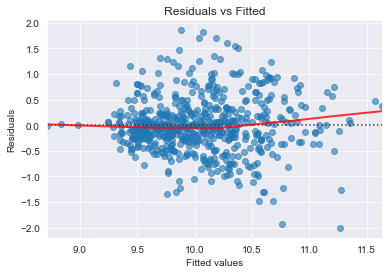

In [70]:
fig_1 = plt.figure(1)
fig_1.axes[0] = sns.residplot(data['hat_log_price'], data['log_price'],
                                  lowess=True,
                                  scatter_kws={'alpha': 0.6},
                                  line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
fig_1.axes[0].set_title('Residuals vs Fitted')
fig_1.axes[0].set_xlabel('Fitted values')
fig_1.axes[0].set_ylabel('Residuals')
plt.show()

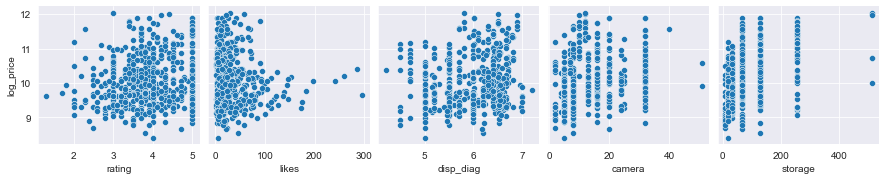

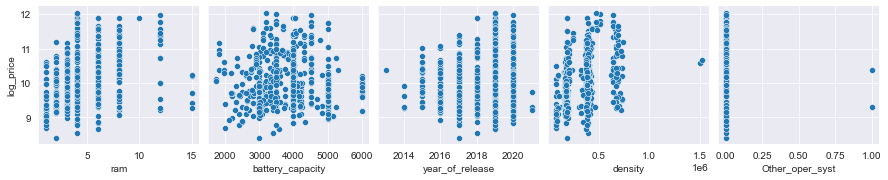

In [71]:
sns.pairplot(data, x_vars=X_columns[0:5], y_vars=["log_price"])
sns.pairplot(data, x_vars=X_columns[5:10], y_vars=["log_price"])
# sns.pairplot(data, x_vars=X_columns[10:15], y_vars=["log_price"]) # Неинтерпретируемые графики
# sns.pairplot(data, x_vars=X_columns[15:20], y_vars=["log_price"]) # Неинтерпретируемые графики
plt.show()

#### 3.1 Тест на проверку гетероскедостичности

$$\begin{align}
&H0: \sigma_{i}^2  = \sigma^2, \forall \ i \in \ \{0,1,2,3,4,5\} \ (гомоскедостичность) \\
&H1: \exists \ i, j : \sigma_{i}^2  \neq \sigma_{k}^2 \ (гетероскедостичность)
\end{align}$$

#### 3.1.1 Тест Уйата

In [73]:
X = data.loc[:, X_columns].copy()
y = data['log_price']
model = sm.OLS(y, X).fit()


In [74]:
white_test = het_white(model.resid,  model.model.exog)


In [75]:
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_white = dict(zip(labels, white_test))
print(f"Chi^2 observed statistic: {res_white['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}") Проверить док
print(f"P-value = {res_white['Chi^2 obserrved statistic p-value']}")

Chi^2 observed statistic: 363.91162309569336
P-value = 5.334443954760367e-10


Нулевая гипотеза о гомоскедостичности остатков отвергается на любом разумном уровне значимости

#### 3.1.2 Бройша-Пагана

In [76]:
bp_test = het_breuschpagan(model.resid,  model.model.exog)
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_bp = dict(zip(labels, bp_test))
print(f"Chi^2 observed statistic: {res_bp['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}")  Проверить док
print(f"P-value = {res_bp['Chi^2 obserrved statistic p-value']}")


Chi^2 observed statistic: 227.55774636613899
P-value = 2.3530624019285324e-31


#### 3.1.3 Тест Голдфелда — Куандта

In [77]:
# goldfeldquandt = het_goldfeldquandt(model.resid,  model.model.exog)
# labels = ['F-statistics observed', 'F-statistics p-value', 'ordering']
# res_goldfeldquandt = dict(zip(labels, goldfeldquandt))
# print(f"F observed statistic: {res_goldfeldquandt['F-statistics observed']}")
# print(f"P-value = {res_goldfeldquandt['F-statistics p-value']}")



### 3.2 Решение проблемы гетероскедостичности

Для решение этой проблемы воспользуюсь робастными оценками в форме Уайта

##### 3.2.1 Общая информации модели до применение робастных оценок

In [78]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     11.85
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.02e-45
Time:                        23:09:56   Log-Likelihood:                -479.06
No. Observations:                 597   AIC:                             1026.
Df Residuals:                     563   BIC:                             1175.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -32.6497     50.958     -0.641      0.522    -132.741      67.441
rating                0.0615      0.035      1.756      0.080      -0.007       0.130
likes                -0.0004      0.001     -0.527      0.598      -0.002       0.001
disp_diag            -0.0462      0.086     -0.537      0.591      -0.215       0.123
camera                0.0103      0.003      2.982      0.003       0.004       0.017
storage               0.0016      0.000      3.464      0.001       0.001       0.002
ram                   0.0452      0.014      3.199      0.001       0.017       0.073
battery_capacity  -6.742e-06   4.91e-05     -0.137      0.891      -0.000    8.97e-05
year_of_release       0.0213      0.025      0.841      0.401      -0.028       0.071
density             4.18e-07   1.82e-07      2.298      0.022    6.07e-08    7.75e-07
Other_oper_syst       0.2782      0.434      0.640      0.522      -0.575       1.131
battery_type_LiPo     0.0112      0.063      0.177      0.860      -0.113       0.136
brand_BlackBerry     -0.9855      0.220     -4.474      0.000      -1.418      -0.553
brand_Cubot          -0.8324      0.261     -3.188      0.002      -1.345      -0.320
brand_Gionee         -1.1634      0.421     -2.766      0.006      -1.989      -0.337
brand_Google         -0.4143      0.214     -1.937      0.053      -0.835       0.006
brand_HTC            -0.9909      0.160     -6.176      0.000      -1.306      -0.676
brand_Honor          -0.6062      0.267     -2.273      0.023      -1.130      -0.082
brand_Hotwav         -1.6733      0.572     -2.924      0.004      -2.798      -0.549
brand_Huawei         -0.9940      0.142     -6.995      0.000      -1.273      -0.715
brand_Infinix        -1.2211      0.162     -7.529      0.000      -1.540      -0.903
brand_LG             -0.5627      0.205     -2.741      0.006      -0.966      -0.160
brand_Lava           -1.6870      0.416     -4.059      0.000      -2.503      -0.871
brand_Lenovo         -1.0483      0.215     -4.871      0.000      -1.471      -0.626
brand_Motorola       -0.2661      0.248     -1.072      0.284      -0.754       0.221
brand_Nokia          -1.0716      0.171     -6.250      0.000      -1.408      -0.735
brand_OnePlus        -0.4097      0.197     -2.083      0.038      -0.796      -0.023
brand_Oppo           -1.0631      0.159     -6.671      0.000      -1.376      -0.750
brand_Realme         -1.0706      0.200     -5.340      0.000      -1.464      -0.677
brand_Samsung        -0.8092      0.140     -5.789      0.000      -1.084      -0.535
brand_Sony           -0.7050      0.210     -3.363      0.001      -1.117      -0.293
brand_Tecno          -0.9540      0.158     -6.027      0.000      -1.265      -0.643
brand_Vivo           -0.8884      0.290     -3.063      0.002      -1.458

##### 3.2.2 Применение робастных оценок

In [79]:
ols_robust = ols.get_robustcov_results()
ols_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     166.6
Date:                Mon, 08 May 2023   Prob (F-statistic):          2.02e-266
Time:                        23:10:00   Log-Likelihood:                -479.06
No. Observations:                 597   AIC:                             1026.
Df Residuals:                     563   BIC:                             1175.
Df Model:                          33                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -32.6497     44.436     -0.735      0.463    -119.930      54.630
rating                0.0615      0.034      1.799      0.073      -0.006       0.129
likes                -0.0004      0.001     -0.797      0.426      -0.001       0.001
disp_diag            -0.0462      0.078     -0.590      0.555      -0.200       0.108
camera                0.0103      0.004      2.588      0.010       0.002       0.018
storage               0.0016      0.001      2.945      0.003       0.001       0.003
ram                   0.0452      0.015      3.004      0.003       0.016       0.075
battery_capacity  -6.742e-06   4.48e-05     -0.151      0.880   -9.47e-05    8.12e-05
year_of_release       0.0213      0.022      0.965      0.335      -0.022       0.065
density             4.18e-07   1.74e-07      2.401      0.017    7.61e-08     7.6e-07
Other_oper_syst       0.2782      0.459      0.607      0.544      -0.623       1.179
battery_type_LiPo     0.0112      0.063      0.177      0.859      -0.113       0.135
brand_BlackBerry     -0.9855      0.242     -4.067      0.000      -1.462      -0.510
brand_Cubot          -0.8324      0.330     -2.525      0.012      -1.480      -0.185
brand_Gionee         -1.1634      0.150     -7.768      0.000      -1.458      -0.869
brand_Google         -0.4143      0.281     -1.475      0.141      -0.966       0.137
brand_HTC            -0.9909      0.134     -7.377      0.000      -1.255      -0.727
brand_Honor          -0.6062      0.400     -1.514      0.131      -1.393       0.180
brand_Hotwav         -1.6733      0.116    -14.431      0.000      -1.901      -1.446
brand_Huawei         -0.9940      0.123     -8.109      0.000      -1.235      -0.753
brand_Infinix        -1.2211      0.134     -9.127      0.000      -1.484      -0.958
brand_LG             -0.5627      0.185     -3.037      0.003      -0.927      -0.199
brand_Lava           -1.6870      0.116    -14.505      0.000      -1.915      -1.459
brand_Lenovo         -1.0483      0.132     -7.971      0.000      -1.307      -0.790
brand_Motorola       -0.2661      0.249     -1.067      0.287      -0.756       0.224
brand_Nokia          -1.0716      0.144     -7.454      0.000      -1.354      -0.789
brand_OnePlus        -0.4097      0.177     -2.315      0.021      -0.757      -0.062
brand_Oppo           -1.0631      0.171     -6.223      0.000      -1.399      -0.728
brand_Realme         -1.0706      0.159     -6.746      0.000      -1.382      -0.759
brand_Samsung        -0.8092      0.124     -6.550      0.000      -1.052      -0.567
brand_Sony           -0.7050      0.184     -3.830      0.000      -1.067      -0.343
brand_Tecno          -0.9540      0.144     -6.614      0.000      -1.237      -0.671
brand_Vivo           -0.8884      0.132     -6.731      0.000      -1.148

### 4. Спецификация модели